[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/Github/GenAI-Showcase/notebooks/agents/mongodb_text_to_MQL_agent_reAct_vs_graph.ipynb)

# Build a Text-to-MQL Agent with MongoDB & LangGraph



This notebook walks through building a **natural language to MongoDB aggregation query (Text-to-MQL)** agent using LangChain, OpenAI, and MongoDB Atlas.

You'll explore two approaches:

1. Try a **prebuilt ReAct agent** using LangChain + MongoDB tools
2. Build a **custom LangGraph agent** with structured, deterministic behavior

Both use the `langchain_mongodb.agent_toolkit`, which gives the agent access to:
- Collection names
- Collection schema and sample docs
- MQL query execution and validation

> Combined with vector search and graph traversal, Text-to-MQL enables structured, semantically meaningful interaction with your database.

---
## Architecture: How it Works

Each query follows a structured process:

1. List collections to understand the data
2. Fetch schema from the relevant collection
3. Generate a MongoDB aggregation pipeline
4. Check and fix the query format
5. Run the query and return results
6. Optionally format or log the output

This flow can be handled by a ReAct-style agent (fast) or a graph-based agent (structured).

---

## Technologies Used

- **MongoDB Atlas** – Data layer with aggregation support
- **LangGraph** – Build deterministic, multi-step agent workflows
- **LangChain** – Integrate LLMs, tools, and memory into agents
- **OpenAI** – Generates pipelines and rewrites invalid ones

---

## Prerequisites

To run this notebook, you’ll need:

- A MongoDB Atlas cluster (with the [`sample_mflix` dataset](https://www.mongodb.com/docs/atlas/sample-data/sample-mflix/) loaded)
  - To load sample datasets in your Atlas cluster, please follow the instructions [here](https://www.mongodb.com/docs/atlas/sample-data/#std-label-load-sample-data).
- An OpenAI API key
- These environment variables set:
  - `MONGODB_URI`
  - `OPENAI_API_KEY`

Let's get started.

## Add IP Address to Atlas cluster

⚠️  Check your public IP — useful for updating MongoDB Atlas network access if needed.

In [6]:
!curl ifconfig.me

35.231.198.42

# Set-up

## Step 1. Install Dependencies  
Installs all necessary Python packages, including LangGraph, LangChain’s MongoDB and OpenAI integrations, and PyMongo for raw DB access.

In [7]:
!pip install -U langgraph langchain-mongodb langchain-openai openai pymongo

## Step 2. Set Environment Variables  

Specify your **MongoDB Atlas connection string** and **OpenAI API key** as environment variables. This allows the agent to connect to your database and generate responses using LLMs.

- **Set the MongoDB connection string**: Follow the steps [here](https://www.mongodb.com/docs/manual/reference/connection-string/) to get the connection string from the Atlas UI.

- **Set the OpenAI API key**: Steps to obtain an API key as [here](https://help.openai.com/en/articles/4936850-where-do-i-find-my-openai-api-key)

In [ ]:
# Environment
import datetime as dt
import json
import os
from pathlib import Path

# Typing
from typing import Literal

from langchain_core.messages import AIMessage
from langchain_mongodb.agent_toolkit import MONGODB_AGENT_SYSTEM_PROMPT

# MongoDB Agent Toolkit
from langchain_mongodb.agent_toolkit.database import MongoDBDatabase
from langchain_mongodb.agent_toolkit.toolkit import MongoDBDatabaseToolkit

# LangChain + OpenAI
from langchain_openai import ChatOpenAI

# LangGraph Core
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, create_react_agent

In [ ]:
# Set your MongoDB Atlas connection string and OpenAI key
os.environ["MONGODB_URI"] = ""
os.environ["OPENAI_API_KEY"] = ""

## Step 3. Initialize MongoDB and LLM  

Connect to your MongoDB Atlas cluster and initialize an OpenAI-compatible LLM for query generation.

We’ll use `MongoDBDatabase` to wrap your database and `ChatOpenAI` as the model.

In [10]:
db = MongoDBDatabase.from_connection_string(
    os.getenv("MONGODB_URI"), database="sample_mflix"
)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## Step 4. Load Tools from the Toolkit  
The `MongoDBDatabaseToolkit` turns your database and LLM into a set of LangChain-compatible tools.

These include:

| Tool Name                 | What It Does                                               |
|---------------------------|------------------------------------------------------------|
| `mongodb_list_collections` | Lists all collections available in the database            |
| `mongodb_schema`          | Returns schema + sample docs for a given collection        |
| `mongodb_query_checker`   | Uses an LLM to validate the generated MQL query            |
| `mongodb_query`           | Executes the final query and returns results               |

In [11]:
toolkit = MongoDBDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()
tool = {t.name: t for t in tools}

print("Tools:", list(tool.keys()))

Tools: ['mongodb_query', 'mongodb_schema', 'mongodb_list_collections', 'mongodb_query_checker']


# Preview `sample_mflix` database and collections

Run basic sanity checks to make sure the sample data and schema introspection works.

This is not required for agents — just helpful grounding.

In [12]:
list(db.get_usable_collection_names())

['comments', 'embedded_movies', 'movies', 'sessions', 'theaters', 'users']

In [13]:
print(db.get_collection_info(["movies"]))

Database name: sample_mflix
Collection name: movies
Schema from a sample of documents from the collection:
_id: ObjectId
plot: String
genres: Array<String>
runtime: Number
cast: Array<String>
num_mflix_comments: Number
poster: String
title: String
fullplot: String
languages: Array<String>
released: Timestamp
directors: Array<String>
writers: Array<String>
awards.wins: Number
awards.nominations: Number
awards.text: String
lastupdated: String
year: Number
imdb.rating: Number
imdb.votes: Number
imdb.id: Number
countries: Array<String>
type: String
tomatoes.viewer.rating: Number
tomatoes.viewer.numReviews: Number
tomatoes.viewer.meter: Number
tomatoes.dvd: Timestamp
tomatoes.lastUpdated: Timestamp

/*
3 documents from movies collection:
[
  {
    "_id": {
      "$oid": "573a1390f29313caabcd63d6"
    },
    "plot": "Two peasant children,",
    "genres": [
      "Fantasy"
    ],
    "runtime": 75,
    "cast": [
      "Tula Belle",
      "Robin Macdougall",
      "Edwin E. Reed",
      "Emma 

In [14]:
print(db.get_collection_info(["comments"]))

Database name: sample_mflix
Collection name: comments
Schema from a sample of documents from the collection:
_id: ObjectId
name: String
email: String
movie_id: ObjectId
text: String
date: Timestamp

/*
3 documents from comments collection:
[
  {
    "_id": {
      "$oid": "5a9427648b0beebeb6957b89"
    },
    "name": "Lisa Rasmussen",
    "email": "lisa_rasmussen@fakegm",
    "movie_id": {
      "$oid": "573a1391f29313caabcd82da"
    },
    "text": "Illo nihil occaecati ",
    "date": {
      "$date": "1976-12-18T08:14:46Z"
    }
  },
  {
    "_id": {
      "$oid": "5a9427648b0beebeb6957bb6"
    },
    "name": "Ellaria Sand",
    "email": "indira_varma@gameofth",
    "movie_id": {
      "$oid": "573a1391f29313caabcd8780"
    },
    "text": "Quidem nesciunt quam ",
    "date": {
      "$date": "1985-02-24T20:04:25Z"
    }
  },
  {
    "_id": {
      "$oid": "5a9427648b0beebeb69579e7"
    },
    "name": "Mercedes Tyler",
    "email": "mercedes_tyler@fakegm",
    "movie_id": {
      "$oid

# Agent 1: Using a Prebuilt ReAct Agent Out-of-the-Box

Let’s start by using a prebuilt LangChain agent with minimal setup.

It automatically selects tools from the toolkit and runs your query end-to-end using the ReAct pattern.

> ⚠️ This version is useful for quick testing, but harder to customize for structured flows or post-processing.




In [15]:
# Pull prompt (or define your own)
system_message = MONGODB_AGENT_SYSTEM_PROMPT.format(top_k=5)

# Create agent
agent_executor = create_react_agent(llm, toolkit.get_tools(), prompt=system_message)

Prompt the agent with a plain English query, and compare it to a ground-truth aggregation pipeline.

##  Query 1: Top 5 movies by IMDB ranking

> Peak IMDb. No irony, just statistically verified greatness.



### Correct, Grounded Answer

In [16]:
query = """db.movies.aggregate([
  { "$match": { "imdb.rating": { "$type": "double" } } },
  { "$sort": { "imdb.rating": -1 } },
  { "$limit": 5 },
  { "$project": { "title": 1, "imdb.rating": 1, "_id": 0 } }
])"""

print(db.run_no_throw(query))

[
  {
    "title": "Band of Brothers",
    "imdb": {
      "rating": 9.6
    }
  },
  {
    "title": "Planet Earth",
    "imdb": {
      "rating": 9.5
    }
  },
  {
    "title": "A Brave Heart: The Lizzie Velasquez Story",
    "imdb": {
      "rating": 9.4
    }
  },
  {
    "title": "The Civil War",
    "imdb": {
      "rating": 9.4
    }
  },
  {
    "title": "The Civil War",
    "imdb": {
      "rating": 9.4
    }
  }
]


### (ReAct) Agent Generated Answer

In [ ]:
example_query_react = "List the top 5 movies with the highest IMDb ratings."

events = agent_executor.stream(
    {"messages": [("user", example_query_react)]},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

List the top 5 movies with the highest IMDb ratings.
================================== Ai Message ==================================
Tool Calls:
  mongodb_list_collections (call_p8frX6iFiB7ESeXY3NenanJZ)
 Call ID: call_p8frX6iFiB7ESeXY3NenanJZ
  Args:
================================= Tool Message =================================
Name: mongodb_list_collections

comments, embedded_movies, movies, sessions, theaters, users
================================== Ai Message ==================================
Tool Calls:
  mongodb_schema (call_K0ka8nskKITtoQtJTCMAwmZn)
 Call ID: call_K0ka8nskKITtoQtJTCMAwmZn
  Args:
    collection_names: movies
================================= Tool Message =================================
Name: mongodb_schema

Database name: sample_mflix
Collection name: movies
Schema from a sample of documents from the collection:
_id: ObjectId
plot: String
genres: Array<String>
runtime: Numb

Test a more complex query involving grouping, filtering, and averages.

The agent should be able to infer which field to aggregate and how to limit by film count.

# Agent 2: Build a Custom LangGraph Agent for Text-to-MQL

Now let’s build a more structured agent using LangGraph.

For more control and reliability, we now build a LangGraph agent that mirrors the planning logic of the ReAct agent—but adds:

- Deterministic tool order
- LLM prompts that enforce structure
- A separate validation step
- Clean formatting and result saving

This is ideal for production use or when you want to trace, audit, or override each step.


## Step 5. Define Core ToolNodes  

Wrap the schema-fetching and query-executing tools in `ToolNode` objects so they can be used inside LangGraph.

In [18]:
schema_node = ToolNode([tool["mongodb_schema"]], name="get_schema")
run_node = ToolNode([tool["mongodb_query"]], name="run_query")

## Step 6. List Available Collections  

Create a deterministic node that fetches the list of collections using `mongodb_list_collections` and summarizes it for the agent.

In [19]:
def list_collections(state: MessagesState):
    call = {
        "name": "mongodb_list_collections",
        "args": {},
        "id": "abc",
        "type": "tool_call",
    }
    call_msg = AIMessage(content="", tool_calls=[call])
    resp = tool["mongodb_list_collections"].invoke(call)
    summary = AIMessage(f"Available collections: {resp.content}")
    return {"messages": [call_msg, resp, summary]}

## Step 7. Invoke the Schema Tool  

Prompt the LLM to select and call the schema tool.

This provides context for generating a grounded, schema-aware query.

In [20]:
def call_get_schema(state: MessagesState):
    llm_with = llm.bind_tools([tool["mongodb_schema"]], tool_choice="any")
    resp = llm_with.invoke(state["messages"])
    return {"messages": [resp]}

## Step 8. Generate Aggregation Pipeline  

The LLM reads the user question + schema and produces an aggregation query by calling the `mongodb_query` tool.

In [21]:
def generate_query(state: MessagesState):
    llm_with = llm.bind_tools([tool["mongodb_query"]])  # no tool_choice ⇒ any
    resp = llm_with.invoke(
        [{"role": "system", "content": MONGODB_AGENT_SYSTEM_PROMPT}] + state["messages"]
    )
    return {"messages": [resp]}

## Step 9: Check & Sanitize Pipeline  

A second prompt acts as a query validator: it checks syntax, formatting, and required fields before the query is executed.

In [22]:
def check_query(state: MessagesState):
    original = state["messages"][-1].tool_calls[0]["args"]["query"]
    resp = llm.bind_tools([tool["mongodb_query"]], tool_choice="any").invoke(
        [
            {"role": "system", "content": MONGODB_AGENT_SYSTEM_PROMPT},
            {"role": "user", "content": original},
        ]
    )
    resp.id = state["messages"][-1].id
    return {"messages": [resp]}

## Step 10: Format the Output  

Once results are returned, we use the LLM to format the answer into clean Markdown — easier to read and share than raw JSON.

In [ ]:
FORMAT_SYS = """
You are an assistant that formats MongoDB query results for end-users.

Input variables
---------------
• {{question}} - the user`s original natural-language query
• {{docs}}     - JSON array of documents returned by the database

Write a concise answer in Markdown:

1. Start with: **Answer to:** “<question>”
2. Present the documents clearly (numbered list, table, paragraph - whatever fits)
3. If the array is empty, say: “I couldn`t find any matching documents.”
Do NOT show the raw JSON.
"""

In [24]:
def format_answer(state):
    raw_json = state["messages"][-1].content
    question = state["messages"][0].content

    llm_msg = [
        {"role": "system", "content": FORMAT_SYS},
        {
            "role": "user",
            "content": f"question: {question}\n\ndocs:\n```json\n{raw_json}\n```",
        },
    ]

    pretty = llm.invoke(llm_msg)
    return {"messages": [AIMessage(content=pretty.content)]}

## Step 11: Persist Results  

Write the answer to a Markdown file and log it in JSONL format so results can be audited or re-used.

In [25]:
def save_answer(state):
    """Save final AIMessage to disk, then pass through unchanged."""
    answer = state["messages"][-1].content
    question = state["messages"][0].content

    # ── overwrite markdown for quick viewing ───────────────────
    Path("last_answer.md").write_text(answer)

    # ── append JSONL log (one line per Q/A) ─────────────────────
    with open("answers.jsonl", "a", encoding="utf-8") as f:
        json.dump(
            {
                "ts": dt.datetime.utcnow().isoformat(timespec="seconds"),
                "question": question,
                "answer": answer,
            },
            f,
            ensure_ascii=False,
        )
        f.write("\n")

    # Produce an AIMessage so LangGraph state remains valid
    return {"messages": [AIMessage(content="Answer saved ✅")]}

## Step 12: Assemble the LangGraph  
Defines the full DAG of agent steps. We define each step of the agent and how data flows between them, including conditional logic for error handling. If no tool-call is present, skip the checker. Ends by compiling the `mongo_agent`.

In [26]:
def need_checker(state: MessagesState) -> Literal[END, "check_query"]:
    """If generate_query produced a tool-call, run the checker; else finish."""
    return "check_query" if state["messages"][-1].tool_calls else END

In [27]:
g = StateGraph(MessagesState)

# -------- nodes (functions or ToolNodes defined earlier) --------
g.add_node("list_collections", list_collections)  # deterministic tool-call
g.add_node("call_get_schema", call_get_schema)  # LLM triggers schema tool
g.add_node("get_schema", schema_node)  # executes mongodb_schema
g.add_node("generate_query", generate_query)  # LLM attaches mongodb_query
g.add_node("check_query", check_query)  # LLM validator / rewriter
g.add_node("run_query", run_node)  # executes pipeline
g.add_node("format_answer", format_answer)  # LLM pretty-prints results
g.add_node("save", save_answer)  # ⬅️  NEW saver node

# -------- edges / flow --------
g.add_edge(START, "list_collections")
g.add_edge("list_collections", "call_get_schema")
g.add_edge("call_get_schema", "get_schema")
g.add_edge("get_schema", "generate_query")

# branch: if tool-call present run checker, else end
g.add_conditional_edges("generate_query", need_checker)

g.add_edge("check_query", "run_query")
g.add_edge("run_query", "format_answer")
g.add_edge("format_answer", "save")  # send to saver
g.add_edge("save", END)  # terminate after saving

# -------- compile the graph --------
mongo_agent = g.compile()

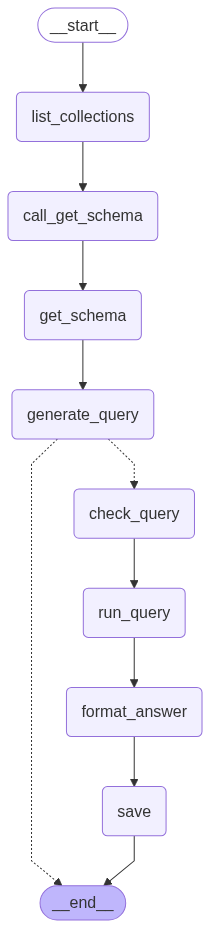

In [28]:
from IPython.display import Image, display

try:
    display(Image(mongo_agent.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Query 2: Directors with ≥20 films, highest avg IMDb rating (top-5)

> Consistency: harder than a third-act twist that lands.



 ### Correct, Grounded Answer

In [ ]:
query = """db.movies.aggregate([
  { "$match": { "imdb.rating": { "$type": "double" } } },
  { "$unwind": "$directors" },
  { "$group": {
      "_id": "$directors",
      "avgRating": { "$avg": "$imdb.rating" },
      "count": { "$sum": 1 }
  }},
  { "$match": { "count": { "$gte": 20 } } },
  { "$sort": { "avgRating": -1 } },
  { "$limit": 5 }
])"""
print(db.run_no_throw(query))

[
  {
    "_id": "William Wyler",
    "avgRating": 7.676190476190476,
    "count": 21
  },
  {
    "_id": "Martin Scorsese",
    "avgRating": 7.640625,
    "count": 32
  },
  {
    "_id": "Alfred Hitchcock",
    "avgRating": 7.5874999999999995,
    "count": 24
  },
  {
    "_id": "Steven Spielberg",
    "avgRating": 7.479310344827587,
    "count": 29
  },
  {
    "_id": "Woody Allen",
    "avgRating": 7.215000000000001,
    "count": 40
  }
]


### (Graph) Agent Generated Answer

In [ ]:
example_query_graph = "Directors with ≥20 films, highest avg IMDb rating (top-5)"

for step in mongo_agent.stream(
    {"messages": [{"role": "user", "content": example_query_graph}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Directors with ≥20 films, highest avg IMDb rating (top-5)
================================== Ai Message ==================================

Available collections: comments, embedded_movies, movies, sessions, theaters, users
================================== Ai Message ==================================
Tool Calls:
  mongodb_schema (call_noC8tmajyqz560ftZDwyrQoc)
 Call ID: call_noC8tmajyqz560ftZDwyrQoc
  Args:
    collection_names: movies
================================= Tool Message =================================
Name: mongodb_schema

Database name: sample_mflix
Collection name: movies
Schema from a sample of documents from the collection:
_id: ObjectId
plot: String
genres: Array<String>
runtime: Number
cast: Array<String>
num_mflix_comments: Number
poster: String
title: String
fullplot: String
languages: Array<String>
released: Timestamp
directors: Array<String>
writers: Array<String>
awards.wins: N

# Example Queries with Graph Agent vs ReAct Agent

Now run real-world natural language queries using the custom LangGraph agent, and compare to the correct MQL.

Includes:
- Most active commenters
- States with most theaters
- Directors with most wins

## Query 3: Most active commenters (top-10 by comment docs)

> *These folks had thoughts. And no character limit.*



### Correct Answer

In [ ]:
query = """db.comments.aggregate([
  { "$group": { "_id": "$name", "total": { "$sum": 1 } } },
  { "$sort":  { "total": -1 } },
  { "$limit": 10 }
])"""
print(db.run_no_throw(query))

[
  {
    "_id": "Mace Tyrell",
    "total": 277
  },
  {
    "_id": "The High Sparrow",
    "total": 260
  },
  {
    "_id": "Rodrik Cassel",
    "total": 260
  },
  {
    "_id": "Missandei",
    "total": 258
  },
  {
    "_id": "Robert Jordan",
    "total": 257
  },
  {
    "_id": "Thoros of Myr",
    "total": 251
  },
  {
    "_id": "Sansa Stark",
    "total": 251
  },
  {
    "_id": "Nicholas Johnson",
    "total": 248
  },
  {
    "_id": "Donna Smith",
    "total": 248
  },
  {
    "_id": "Beric Dondarrion",
    "total": 247
  }
]


### ReAct Agent

In [ ]:
example_query_react = "Who are the top 10 most active commenters?"

events = agent_executor.stream(
    {"messages": [("user", example_query_react)]},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Who are the top 10 most active commenters?
================================== Ai Message ==================================
Tool Calls:
  mongodb_list_collections (call_K67qTEzVB2qbav8yObjD5YVO)
 Call ID: call_K67qTEzVB2qbav8yObjD5YVO
  Args:
================================= Tool Message =================================
Name: mongodb_list_collections

comments, embedded_movies, movies, sessions, theaters, users
================================== Ai Message ==================================
Tool Calls:
  mongodb_schema (call_WZuLuTZvhbMzLSMA6W7IT0Ww)
 Call ID: call_WZuLuTZvhbMzLSMA6W7IT0Ww
  Args:
    collection_names: comments
  mongodb_schema (call_YJmldPQJbIqX78li35HKGHTC)
 Call ID: call_YJmldPQJbIqX78li35HKGHTC
  Args:
    collection_names: users
================================= Tool Message =================================
Name: mongodb_schema

Database name: sample_mflix
Collection name: users
S

### Graph Agent

In [33]:
example_query_graph = "Who are the top 10 most active commenters?"

for step in mongo_agent.stream(
    {"messages": [{"role": "user", "content": example_query_graph}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Who are the top 10 most active commenters?
================================== Ai Message ==================================

Available collections: comments, embedded_movies, movies, sessions, theaters, users
================================== Ai Message ==================================
Tool Calls:
  mongodb_schema (call_5uZ4iSAJZXSEJinwJazphcTs)
 Call ID: call_5uZ4iSAJZXSEJinwJazphcTs
  Args:
    collection_names: comments, users
================================= Tool Message =================================
Name: mongodb_schema

Database name: sample_mflix
Collection name: comments
Schema from a sample of documents from the collection:
_id: ObjectId
name: String
email: String
movie_id: ObjectId
text: String
date: Timestamp

/*
3 documents from comments collection:
[
  {
    "_id": {
      "$oid": "5a9427648b0beebeb6957b89"
    },
    "name": "Lisa Rasmussen",
    "email": "lisa_rasmussen@fakegm",
   

## Query 4: States with the most theaters (top-5)

> *Where the real estate market is second only to the Marvel Cinematic Universe.*



### Correct Answer

In [ ]:
query = """db.theaters.aggregate([
  { "$group": { "_id": "$location.address.state", "numTheaters": { "$sum": 1 } } },
  { "$sort":  { "numTheaters": -1 } },
  { "$limit": 5 }
])"""
print(db.run_no_throw(query))

[
  {
    "_id": "CA",
    "numTheaters": 169
  },
  {
    "_id": "TX",
    "numTheaters": 160
  },
  {
    "_id": "FL",
    "numTheaters": 111
  },
  {
    "_id": "NY",
    "numTheaters": 81
  },
  {
    "_id": "IL",
    "numTheaters": 70
  }
]


### ReAct agent

In [ ]:
example_query_react = "Which states have the most theaters?"

events = agent_executor.stream(
    {"messages": [("user", example_query_react)]},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Which states have the most theaters?
================================== Ai Message ==================================
Tool Calls:
  mongodb_list_collections (call_z4rLKuvRdYFBMSRzeC3hFW0T)
 Call ID: call_z4rLKuvRdYFBMSRzeC3hFW0T
  Args:
================================= Tool Message =================================
Name: mongodb_list_collections

comments, embedded_movies, movies, sessions, theaters, users
================================== Ai Message ==================================
Tool Calls:
  mongodb_schema (call_QWX7cIaNS0iHumbNF6rUi0sl)
 Call ID: call_QWX7cIaNS0iHumbNF6rUi0sl
  Args:
    collection_names: theaters
================================= Tool Message =================================
Name: mongodb_schema

Database name: sample_mflix
Collection name: theaters
Schema from a sample of documents from the collection:
_id: ObjectId
theaterId: Number
location.address.street1: String
location.

### Graph agent

In [ ]:
example_query_graph = "Which states have the most theaters?"
for step in mongo_agent.stream(
    {"messages": [{"role": "user", "content": example_query_graph}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which states have the most theaters?
================================== Ai Message ==================================

Available collections: comments, embedded_movies, movies, sessions, theaters, users
================================== Ai Message ==================================
Tool Calls:
  mongodb_schema (call_WhgtKXCAdxNKvO1BCA41X24C)
 Call ID: call_WhgtKXCAdxNKvO1BCA41X24C
  Args:
    collection_names: theaters
================================= Tool Message =================================
Name: mongodb_schema

Database name: sample_mflix
Collection name: theaters
Schema from a sample of documents from the collection:
_id: ObjectId
theaterId: Number
location.address.street1: String
location.address.city: String
location.address.state: String
location.address.zipcode: String
location.geo.type: String
location.geo.coordinates: Array<Number>

/*
3 documents from theaters collection:
[
  {
    "_id"

## Query 5: Theaters furthest west (smallest longitude) – top-5

> *Go any farther west and you're in the Pacific.*



### Correct Answer

In [ ]:
query = """db.theaters.aggregate([
  { "$project": {
      "theaterId": 1,
      "city": "$location.address.city",
      "lon": { "$arrayElemAt": [ "$location.geo.coordinates", 0 ] },
      "_id": 0
  }},
  { "$sort":  { "lon": 1 } },
  { "$limit": 5 }
])"""
print(db.run_no_throw(query))

[
  {
    "theaterId": 852,
    "city": "Aiea",
    "lon": -157.9497
  },
  {
    "theaterId": 8140,
    "city": "Honolulu",
    "lon": -157.919795
  },
  {
    "theaterId": 8153,
    "city": "Honolulu",
    "lon": -157.919795
  },
  {
    "theaterId": 8183,
    "city": "Honolulu",
    "lon": -157.919795
  },
  {
    "theaterId": 8152,
    "city": "Honolulu",
    "lon": -157.919795
  }
]


### ReAct agent

In [ ]:
example_query_react = "Which theaters are furthest west?"

events = agent_executor.stream(
    {"messages": [("user", example_query_react)]},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Which theaters are furthest west?
================================== Ai Message ==================================
Tool Calls:
  mongodb_list_collections (call_1i3nkgUBuPAQOUAr4Eq8Lkjg)
 Call ID: call_1i3nkgUBuPAQOUAr4Eq8Lkjg
  Args:
================================= Tool Message =================================
Name: mongodb_list_collections

comments, embedded_movies, movies, sessions, theaters, users
================================== Ai Message ==================================
Tool Calls:
  mongodb_schema (call_zIkFRdEJdE6iFVgTMAy7DJPT)
 Call ID: call_zIkFRdEJdE6iFVgTMAy7DJPT
  Args:
    collection_names: theaters
================================= Tool Message =================================
Name: mongodb_schema

Database name: sample_mflix
Collection name: theaters
Schema from a sample of documents from the collection:
_id: ObjectId
theaterId: Number
location.address.street1: String
location.add

### Graph agent

In [ ]:
example_query_graph = "Which theaters are furthest west?"
for step in mongo_agent.stream(
    {"messages": [{"role": "user", "content": example_query_graph}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which theaters are furthest west?
================================== Ai Message ==================================

Available collections: comments, embedded_movies, movies, sessions, theaters, users
================================== Ai Message ==================================
Tool Calls:
  mongodb_schema (call_oZEJkYvisLxULE9P9yUEdIam)
 Call ID: call_oZEJkYvisLxULE9P9yUEdIam
  Args:
    collection_names: theaters
================================= Tool Message =================================
Name: mongodb_schema

Database name: sample_mflix
Collection name: theaters
Schema from a sample of documents from the collection:
_id: ObjectId
theaterId: Number
location.address.street1: String
location.address.city: String
location.address.state: String
location.address.zipcode: String
location.geo.type: String
location.geo.coordinates: Array<Number>

/*
3 documents from theaters collection:
[
  {
    "_id": {

## Query 6: Top 5 winning directors with at least 5 movies

Identifies the top 5 directors with the highest total award wins, filtering for those with at least 5 films and aggregating across unwound director fields.

> *Only directors who’ve been around long enough to be snubbed at least once.*

### Correct Answer

In [40]:
query = """db.movies.aggregate([
  { "$match": { "awards.wins": { "$type": "int" } } },
  { "$unwind": "$directors" },
  { "$group": {
      "_id": "$directors",
      "totalWins": { "$sum": "$awards.wins" },
      "filmCount": { "$sum": 1 }
  }},
  { "$match": { "filmCount": { "$gte": 5 } } },
  { "$sort":  { "totalWins": -1 } },
  { "$limit": 5 },
  { "$project": { "_id": 0, "director": "$_id", "totalWins": 1, "filmCount": 1 } }
])"""

print(db.run_no_throw(query))

[
  {
    "totalWins": 699,
    "filmCount": 29,
    "director": "Steven Spielberg"
  },
  {
    "totalWins": 587,
    "filmCount": 32,
    "director": "Martin Scorsese"
  },
  {
    "totalWins": 576,
    "filmCount": 8,
    "director": "Alfonso Cuar\u00e8n"
  },
  {
    "totalWins": 526,
    "filmCount": 13,
    "director": "Peter Jackson"
  },
  {
    "totalWins": 496,
    "filmCount": 18,
    "director": "Joel Coen"
  }
]


### ReAct Agent

In [41]:
# ReAct agent
example_query_react = (
    "Who are the top 5 directors with the most award wins and at least 5 movies?"
)

events = agent_executor.stream(
    {"messages": [("user", example_query_react)]},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Who are the top 5 directors with the most award wins and at least 5 movies?
================================== Ai Message ==================================
Tool Calls:
  mongodb_list_collections (call_HLPh3FgUkLkDVrXqzCzlOCPx)
 Call ID: call_HLPh3FgUkLkDVrXqzCzlOCPx
  Args:
================================= Tool Message =================================
Name: mongodb_list_collections

comments, embedded_movies, movies, sessions, theaters, users
================================== Ai Message ==================================
Tool Calls:
  mongodb_schema (call_yKw2rqr1xbpMYDv54WS8GSJ5)
 Call ID: call_yKw2rqr1xbpMYDv54WS8GSJ5
  Args:
    collection_names: movies
  mongodb_schema (call_U3ePkit9MVpYqkGftpTGhwQS)
 Call ID: call_U3ePkit9MVpYqkGftpTGhwQS
  Args:
    collection_names: comments
================================= Tool Message =================================
Name: mongodb_schema

Database name: sam

### Graph Agent

In [42]:
# Graph agent
example_query_graph = (
    "Who are the top 5 directors with the most award wins and at least 5 movies?"
)
for step in mongo_agent.stream(
    {"messages": [{"role": "user", "content": example_query_graph}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Who are the top 5 directors with the most award wins and at least 5 movies?
================================== Ai Message ==================================

Available collections: comments, embedded_movies, movies, sessions, theaters, users
================================== Ai Message ==================================
Tool Calls:
  mongodb_schema (call_pAsJOf8G85qkoA2qoIZIUYMZ)
 Call ID: call_pAsJOf8G85qkoA2qoIZIUYMZ
  Args:
    collection_names: movies
================================= Tool Message =================================
Name: mongodb_schema

Database name: sample_mflix
Collection name: movies
Schema from a sample of documents from the collection:
_id: ObjectId
plot: String
genres: Array<String>
runtime: Number
cast: Array<String>
num_mflix_comments: Number
poster: String
title: String
fullplot: String
languages: Array<String>
released: Timestamp
directors: Array<String>
writers: Array<Stri